In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2
from cv2 import xfeatures2d 
import math
import matplotlib as mplt
import shutil
import matplotlib.pyplot as plt
from PIL import Image

import os
import sys

In [44]:
#nrrd_path ="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/negetive_axon_bouton"
nrrd_path ="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/17302_axon_tip"
tif_path="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/17302_axon_tip_mip/"  #project result of xy
tif_save_re="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/ne_re_tip/"         #bouton around tip
tif_save_out="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/ne_re_tip_out/"   #no bouton around tip
tif_save_no="/home/braincenter5/Desktop/bouton_detection/17302s/axon_test_11.18/ne_re_tip_no/"    #no bouton in block
mip_dict = {'XY':0, 'XZ':1, 'YZ':2}

if os.listdir(tif_path):
    shutil.rmtree(tif_path) 
    os.mkdir(tif_path)
if os.listdir(tif_save_re):
    shutil.rmtree(tif_save_re) 
    os.mkdir(tif_save_re)
if os.listdir(tif_save_out):
    shutil.rmtree(tif_save_out) 
    os.mkdir(tif_save_out)
if os.listdir(tif_save_no):
    shutil.rmtree(tif_save_no)
    os.mkdir(tif_save_no)
def plot_mip(nrrd, ax=None, mip_direction='XY'):
    img = sitk.ReadImage(nrrd)
    #img = img.transpose(Image.ROTATE_180)
    array = sitk.GetArrayFromImage(img)
    mip = np.max(array, axis=mip_dict[mip_direction])

    if ax is None:
        plt.imshow(mip, cmap='Greys_r')
        plt.axis('off')
    else:
        ax.imshow(mip, cmap='Greys_r')
        ax.axis('off')
    return mip

In [45]:
def sift_tif(tif_path):
    img = cv2.imread(tif_path)
    #print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(0,3,0.04,30,1.6)
    keypoints, descriptor = sift.detectAndCompute(gray, None)
    return (keypoints,img)

In [369]:
cv2.xfeatures2d.SIFT_create?

Bouton around 6813/12339 tip is detected!
No bouton in 1164 block is detected!
No bouton around 0 tip is detected!


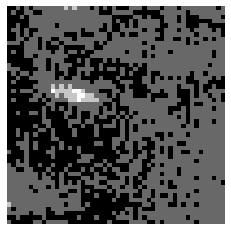

In [46]:
if __name__ == '__main__':
    #nrrd_path = sys.argv[1]
    #nrrd_path_save = sys.argv[2]
    if not nrrd_path.endswith("/"):
        nrrd_path = nrrd_path + '/'
        
    sample_list = sorted([i for i in os.listdir(nrrd_path) if i.endswith("tif")])
    for n_sample, nrrd in enumerate(sample_list):
        block_id = "_".join(nrrd.split("_")[2:6])
        mip = plot_mip(nrrd_path + nrrd, None,mip_direction='XY')
        cv2.imwrite(tif_path+nrrd,mip)
    
    count_tip=0
    count_block=0
    count_all_out=0
    tif_list = sorted([i for i in os.listdir(tif_path) if i.endswith("tif")])
    for n_sample, tif in enumerate(tif_list):
        keypoints,img=sift_tif(tif_path+tif) 
        img_out=img
        if len(keypoints)!=0:
            count_in=0
            count_out=0
            out=[]
            tip=[]
            for i in range(len(keypoints)):
                dis=math.sqrt((int(keypoints[i].pt[0])-25)**2+(int(keypoints[i].pt[1])-25)**2)
                if(dis<=5):
                    tip.append(i)
                    count_in+=1
                else:
                    out.append(i)
                    count_out+=1
            if (count_in!=0):
                #cv2.circle(img,(int(keypoints[min(tip)].pt[0]),int(keypoints[min(tip)].pt[1])),3,(0,255,0),1)
                cv2.imwrite(tif_save_re+tif,img)
                count_tip+=1 
            #if ((count_in==0) and (count_out!=0)):
            #    for i in out:
            #        cv2.circle(img,(int(keypoints[i].pt[0]),int(keypoints[i].pt[1])),3,(0,0,255),1)
            #    cv2.imwrite(tif_save_out+tif,img_out)
            #    count_all_out+=1
        else:
            cv2.imwrite(tif_save_no+tif,img)
            count_block+=1
    print("Bouton around %d/%d tip is detected!" % (count_tip,len(sample_list))) 
    print("No bouton in %d block is detected!" % count_block)
    print("No bouton around %d tip is detected!" % count_all_out)
    


# below is cutting 3D tif image in Z and using SIFT for bouton detection.

In [44]:
def sift_tif(tif_path):
    img = cv2.imread(tif_path)
    #print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(0,6,0.04,10,1)
    keypoints, descriptor = sift.detectAndCompute(gray, None)
    return (keypoints,img)

In [45]:
def cut_z_mip_sift(input_tif_path,cut_nums):  #input a tif folder
    
    tif_list=get_list(input_tif_path,".tif")
    for tifs in tif_list: #go through every tif
        
        
        list_name=tifs.split(".")
        del(list_name[-1])
        flag=str(".".join(list_name))
        #print(flag)
        tif_l1=input_tif_path+flag+"/"
        tif_l2_mip_cut=input_tif_path+flag+"/mip_cut/"
        tif_l2_sift_cut=input_tif_path+flag+"/sift_cut/"
        tif_l2_sift_all=input_tif_path+flag+"/sift_mip_all/"
    
        if os.path.exists(tif_l1):
            shutil.rmtree(tif_l1) 
            os.mkdir(tif_l1)
        else:
            os.mkdir(tif_l1)
        

        os.mkdir(tif_l2_mip_cut)
        os.mkdir(tif_l2_sift_cut)
        os.mkdir(tif_l2_sift_all)
            
        img = sitk.ReadImage(input_tif_path+tifs)
        
        img_array = np.array(sitk.GetArrayFromImage(img), dtype='int32')
        aver=np.mean(img_array)
        his=np.quantile(img_array, .99)
        #print(his,aver,img_array[50,50,50])
        
    
        #print(img_array.shape)
        #img_array = img_array.transpose(Image.ROTATE_180)
        #img_array.reverse()
       
       #mip and sift image with Z-cut
        index=0
        x=[]
        y=[]
        z=[]
        name=[]
        mip_dict={'XY':0,'XZ':1,'YZ':2}
        for i in range(int(img_array.shape[0] / cut_nums)):#go through every cut_tif
            img_cut = img_array[i*cut_nums:(i+1)*cut_nums,:,:]
            mip_cut = np.max(img_cut, axis=mip_dict['XY'])   
            flag_cut=str(i*cut_nums)+"_"+str((i+1)*cut_nums) #cut tif name
            cv2.imwrite(tif_l2_mip_cut+flag_cut+"_mip.tif",mip_cut)
            k_sift,img_sift=sift_tif(tif_l2_mip_cut+flag_cut+"_mip.tif")
           
            for j in range(len(k_sift)):#go through every keypoint
                if '%.2f' % k_sift[j].pt[0] not in x and '%.2f' % k_sift[j].pt[1] not in y:#make sure no dumplicated 
                    index=index+1
                    x.append('%.2f' % (k_sift[j].pt[0]+1))
                    y.append('%.2f' % ((img_array.shape[0]-float(k_sift[j].pt[1]))+1))#image about y=imagesize/2 symmetry
                    z.append((i+i+1)*cut_nums/2+1)
                    name.append(flag_cut)
                cv2.circle(img_sift,(int(k_sift[j].pt[0]),int(k_sift[j].pt[1])),3,(0,255,0),1)

            cv2.imwrite(tif_l2_sift_cut+flag_cut+"_sift.tif",img_sift)
            
        dataframe_csv = pd.DataFrame({'index':range(index),'x':x,'y':y,'z':z})
        dataframe_marker = pd.DataFrame({'##x':x,'y':y,'z':z,'radius':1,'shape':0,'name':name,'comment':0,
                                         'color_r':255,'color_g':0,'color_b':0})
        dataframe_marker.to_csv(input_tif_path+"/"+flag+"_keypoints.marker",index=False,sep=',')
        
        #mip and sift image with whole image  
        mip_all = np.max(img_array, axis=mip_dict['XY'])    
        cv2.imwrite(tif_l2_sift_all+"0_50_mip.tif",mip_all)
        k_sift,img_sift=sift_tif(tif_l2_sift_all+"0_50_mip.tif")
        for j in range(len(k_sift)):
            cv2.circle(img_sift,(int(k_sift[j].pt[0]),int(k_sift[j].pt[1])),3,(0,255,0),1)
        cv2.imwrite(tif_l2_sift_all+"0_50_sift.tif",img_sift)
            
    return 0


def cut_z_mip_one_img(img_array,cut_nums,save_path): #input a image array and a save path
       
    for i in range(int(img_array.shape[0] / cut_nums)):
        img_cut = img_array[i*cut_nums:(i+1)*cut_nums,:,:]
        mip_cut = np.max(img_cut, axis=mip_dict['XY'])    
        cv2.imwrite(save_path+str(i*cut_nums)+"_"+str((i+1)*cut_nums)+"_mip.tif",mip_cut)
        k_sift,img_sift=sift_tif(save_path+str(i*cut_nums)+"_"+str((i+1)*cut_nums)+"_mip.tif")
        for j in range(len(k_sift)):
            cv2.circle(img_sift,(int(k_sift[j].pt[0]),int(k_sift[j].pt[1])),3,(0,255,0),1)
        cv2.imwrite(save_path+str(i*cut_nums)+"_"+str((i+1)*cut_nums)+"_sift.tif",img_sift)
    return 0

def get_list_(tif_path,suffix):
    ct = 0
    tif_files = []
    for file in sorted(os.listdir(tif_path)):
        if file.endswith(suffix):
            ct += 1
            tif_files.append(file)
    print("%d tifs" % ct)
    return tif_files



In [46]:
input_tif_path="/home/braincenter5/Desktop/bouton_detection/for_allen/mouse17782-3487/"#input a tif folder
cut_z_mip_sift(input_tif_path,2)

3608 tifs


0

# below is calculating the distance for deleting dumplicated nodes

In [9]:
def refine_marker(marker_path,files,size):
    flag_x=(files.split("_x")[1]).split("_")[0]
    flag_y=(files.split("_y")[1]).split("_")[0]
    flag_z=(files.split("_z")[1]).split("_")[0]
    #x_ori=flag[0][1:]
    #y_ori=flag[1][1:]
    #z_ori=flag[2][1:]
    print('#ori_x:%s,ori_y:%s,ori_z:%s' % (flag_x,flag_y,flag_z))
    x_offset=float(flag_x)-size/2
    y_offset=float(flag_y)-size/2
    z_offset=float(flag_z)-size/2
    
    #result list
    x=[]
    y=[]
    z=[]
    
    #read markerfile
    data_marker=pd.read_csv(marker_path+"/"+files)
    if data_marker.empty:
        return 0,0,0
    
    #read swc file
    swc_name="_x"+flag_x+"_y"+flag_y+"_z"+flag_z
    prefix_name=files.split("_k")[0]
    data_swc=pd.read_csv(marker_path+"/"+prefix_name+".swc",sep='/t',header=None)

    #delete nodes whose type != 2
    if len(data_swc)==0:
        return 0,0,0
    else:
        for i in reversed(range(len(data_swc))):
            prefix=str(data_swc.iloc[i][0])
            print(prefix)
            if prefix.startswith( "#" ):#exclude the title line
                data_swc=data_swc.drop([i]) 
                continue
            if len(prefix.split(' '))>2:
                if int(prefix.split(' ')[1])!=2:#exclude the nodes whose type!=2
                    data_swc=data_swc.drop([i])
                

    #delete dumplicated nodes
    x.append(data_marker.iloc[0][0])#put the fisrt node firstly
    y.append(data_marker.iloc[0][1])
    z.append(data_marker.iloc[0][2])
    for i in range(len(data_marker)):     
        #exclude nodes whose distance less than 3
        x1=data_marker.iloc[i][0]
        y1=data_marker.iloc[i][1]
        z1=data_marker.iloc[i][2]
        num1=0
        for j in range(len(x)):
            x2=x[j]
            y2=y[j]
            z2=z[j]
            dis=math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
            if dis<3:
                num1=num1+1
                break
                
        #exclude nodes 7piexls far away from swc nodes    
        drop=False
        if len(data_swc)!=0:
            num2=0
            for k in range(len(data_swc)):
                    prefix_for_cor=str(data_swc.iloc[k][0])
                    if len(prefix_for_cor.split(' '))>5:
                        x3=float(prefix_for_cor.split(' ')[2])
                        y3=float(prefix_for_cor.split(' ')[3])
                        z3=float(prefix_for_cor.split(' ')[4])
                        #print(x3,y3,z3)
                        dis_no=math.sqrt((x1-x3)**2+(y1-y3)**2+(z1-z3)**2)  
                        #print(dis_no)
                        if len(x)!=0:#calculate the first
                            dis_first=math.sqrt((float(x[0])-x3)**2+(float(y[0])-y3)**2+(float(z[0])-z3)**2)
                        if dis_first<7:
                            num2=num2+1
                        if num1==0 and dis_no<7:
                            x.append(x1)
                            y.append(y1)
                            z.append(z1)
                            drop=True
                            break
    
    if num2==0 and len(x)!=0:
        x.remove(x[0])
        y.remove(y[0])
        z.remove(z[0])
    dataframe_marker = pd.DataFrame({'##x':x,'y':y,'z':z,'radius':1,'shape':0,'name':0,'comment':0,
                                         'color_r':255,'color_g':0,'color_b':0})
    dataframe_marker.to_csv(marker_path+"/"+swc_name+"_refined2.marker",index=False,sep=',')
    #print(data_marker) 
    xr=['%.2f' % (float(i)+x_offset) for i in x]
    yr=['%.2f' % (float(i)+y_offset) for i in y]
    zr=['%.2f' % (float(i)+z_offset) for i in z]
    return xr,yr,zr
    

In [3]:
def get_list(tif_path,suffix):
    ct = 0
    tif_files = []
    for file in sorted(os.listdir(tif_path)):
        if file.endswith(suffix):
            ct += 1
            tif_files.append(file)
    print("%d tifs" % ct)
    return tif_files

In [4]:
#x,y,z=refine_marker('/home/braincenter5/Desktop/test22','RES(24275x37800x10955)_TeraSub_x27675_y12195_z5175_keypoints_shift2.marker',100)

In [5]:
def refine_marker_2terafly(marker_path,suffix):
    marker_list=get_list(marker_path,suffix)
    x=[]
    y=[]
    z=[]
    for num,files in enumerate(marker_list):
        print('#%d maker,name:%s' % (num,str(files)))
        x_marker,y_marker,z_marker=refine_marker(marker_path,files,100)
        if x_marker!=0 and y_marker!=0 and z_marker!=0:           
            x=x+x_marker
            y=y+y_marker
            z=z+z_marker
            print(len(x_marker),len(y_marker),len(z_marker))
    name=str("_".join(marker_list[0].split("_")[0:5]))
    dataframe_marker = pd.DataFrame({'##n':range(len(x)),'orderinfo':0,'name':0,'comment':0,'z':z,'x':x,'y':y,
                                     'pixmax':0,'intensity':0,'sdev':0,'volsize':0,'mass':0,
                                         'color_r':255,'color_g':0,'color_b':0})
    dataframe_marker.to_csv(marker_path+"/"+name+".apo",index=False,sep=',')
    
    return 0

In [10]:
refine_marker_2terafly('/home/braincenter5/Desktop/1.14_boouton_test','_shift3.marker')
#input markerfile folder and markerfile suffix

1 tifs
#0 maker,name:RES(28000x45000x11786)_TeraSub_x11385.000_y10845.000_z3285.000_keypoints_shift3.marker
#ori_x:11385.000,ori_y:10845.000,ori_z:3285.000
67 2 82 78 82 1 66 1 0 0 0 0
66 2 80.077 78.5498 82 1 65 1 0 0 0 0
65 2 78.3394 79.5117 82 1 64 1 0 0 0 0
64 2 76.652 80.5852 82 1 55 1 0 0 0 0
63 2 79 97 82 1 62 0 0 0 0 0
62 2 78.5395 95.0614 82 1 61 0 0 0 0 0
61 2 77.6895 93.251 82 1 60 0 0 0 0 0
60 2 76.8395 91.4406 82 1 59 0 0 0 0 0
59 2 76.1074 89.6031 82 1 58 0 0 0 0 0
58 2 76.0825 87.6033 82 1 57 0 0 0 0 0
57 2 76.0575 85.6034 82 1 56 0 0 0 0 0
56 2 76.0325 83.6036 82 1 55 0 0 0 0 0
55 2 76.0075 81.6038 82 1 54 0 0 0 0 0
54 2 75.6164 79.6575 82 1 53 0 0 0 0 0
53 2 75.1035 77.7285 82 1 52 0 0 0 0 0
52 2 75.0107 75.7307 82 1 51 0 0 0 0 0
51 2 74.9179 73.7328 82 1 50 0 0 0 0 0
50 2 74.3117 71.8893 82 1 49 0 0 0 0 0
49 2 73.1582 70.2696 82 1 48 0 0 0 0 0
48 2 72.3529 68.4389 82 1 47 0 0 0 0 0
47 2 72.024 66.4951 81.913 1 46 0 0 0 0 0
46 2 72 64.5587 81.4454 1 45 0 0 0 0 0
45 2 7

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


6 6 6


0

# below is for evaluating the refinement using center signal peak(3D)

In [105]:
def get_intensity_3d_ring(img, x, y, z, r):
    if r==0:
        return img[z,y,x]
    #print(img[x,y,z])
    ct = 0
    intensity=0
    xa = max(int(x-0.5) - r, 0)
    xb = min(int(x-0.5) + r + 1, img.shape[0])
    ya = max(int(y-0.5) - r, 0)
    yb = min(int(y-0.5) + r + 1, img.shape[1])
    za = max(int(z-0.5) - r, 0)
    zb = min(int(z-0.5) + r + 1, img.shape[2])
    
    tp = np.zeros(img.shape)
    
    for i in range(xa, xb):
        for j in range(ya, yb):
            for k in range(za, zb):
                dist = np.sqrt((x-i)**2 + (y-j)**2 + (z-k)**2)
                if dist>r or dist<(r-1):
                    continue
                ct = ct + 1
                #print(img[k,j,i])
                intensity = intensity + img[k,j,i]
    #print(ct)
    if ct>0:
        intensity = intensity / ct
    return intensity

In [106]:
img = sitk.ReadImage('/home/braincenter5/Desktop/test22/ring_test/1111.tif')
img_array = np.array(sitk.GetArrayFromImage(img))
# data=img_array[:,60:80,:]
# img1 = sitk.GetImageFromArray(data)
# sitk.WriteImage(img1,'/home/braincenter5/Desktop/test22/ring_test/yyy.tif')
# PS:    #data=img_array[:,60:80,:] 
#        #x and z are normal,ya=100-y2,yb=100-y1;
#        #ya=60,yb=80;y1 and y2 are what you want in original image
print(img_array.shape)
ints=[]
for i in range(10):
    ins=get_intensity_3d_ring(img_array,72,100-24,86,i)
    ints.append(ins)
print(ints)

(100, 100, 100)
[32, 50.0, 35.03448275862069, 25.72043010752688, 20.795031055900623, 16.82758620689655, 15.093821510297483, 14.272552783109404, 13.657219973009447, 13.160621761658032]


In [2]:
#delete title line
swc=pd.read_csv('/home/braincenter5/Desktop/test22/ring_test/test_re',sep='/t',header=None)
for i in range(len(swc)):
    prefix=str(swc.iloc[i][0])
    if prefix.startswith( "#" ):
        continue
    #else:
    #    print(prefix.split(' ')[2])
#print(len(swc))
for i in reversed(range(len(swc))):
    #print(i,swc.iloc[i][0])
    prefix=str(swc.iloc[i][0])
    if prefix.startswith( "#" ):
        swc=swc.drop([i]) 
    if len(prefix.split(' '))>2:
        if int(prefix.split(' ')[1])!=2:#exclude the nodes whose type!=2
            swc=swc.drop([i])
#print(swc)

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# below is for evaluating the refinement using center signal peak(2D)

In [11]:
mip_dict={'XY':0,'XZ':1,'YZ':2}
def get_intensity_2d(img, x, y, r):
    if r==0:
        return img[x,y]
    ct = 0
    intensity=0
    #r = int(r+0.5)
    xa = max(int(x-0.5) - r, 0)
    xb = min(int(x-0.5) + r + 1, img.shape[0])
    ya = max(int(y-0.5) - r, 0)
    yb = min(int(y-0.5) + r + 1, img.shape[1])
    
    tp = np.zeros(img.shape)
    
    for i in range(xa, xb):
        for j in range(ya, yb):
            dist = np.sqrt((x-i)**2 + (y-j)**2)
            if dist>r:
                continue
            ct = ct + 1
            intensity = intensity + img[i,j]
    #print(ct)
    if ct>0:
        intensity = intensity / ct
    return intensity


def go_through_swc(swc_path,swc_name):
    swc=pd.read_csv(swc_path+'/'+swc_name,sep='/t',header=None)
    x=[]
    y=[]
    parent=[]
    for i in reversed(range(len(swc))):
    #print(i,swc.iloc[i][0])
        prefix=str(swc.iloc[i][0])
        if prefix.startswith( "#" ):#exclude the lines who startswith '#'
            continue
            #swc=swc.drop([i]) 
        if len(prefix.split(' '))>2:
            if int(prefix.split(' ')[1])!=2:#exclude the nodes whose type!=2
                continue
                #swc=swc.drop([i])
            else:
                x.append(float(prefix.split(' ')[2]))
                y.append(float(prefix.split(' ')[3]))
                parent.append(prefix.split(' ')[6])
    dataframe_swc = pd.DataFrame({'##n,':range(len(x)),'type,':2,'x,':x,'y,':y,'z,':0,'radius,':1,'parent':parent})
    dataframe_swc.to_csv(swc_path+"/"+swc_name+"_2D.swc",index=False,sep=' ')    
    y = [100-i for i in y] #y=100-y!!!
    return x,y #tere are the final x&y match with mip array iamge!


In [12]:
def vertical_line(swc_path,swc_name,image_size,line_half_length):
    swc=pd.read_csv(swc_path+'/'+swc_name,sep='/t',header=None)
    n_pn={}
    n_i={}
    num=0
    
    #get n_np and n_i
    for i in range(len(swc)):
        prefix=str(swc.iloc[i][0])
        if prefix.startswith( "#" ):#exclude the lines who startswith '#'
            continue 
        if len(prefix.split(' '))>2:
            if int(prefix.split(' ')[1])!=2:#exclude the nodes whose type!=2
                continue
            elif int(prefix.split(' ')[6])==-1:
                num=num-1 #change all root node to -1,-2,-3,-4...
                n_pn[int(prefix.split(' ')[0])]=num
                n_i[int(prefix.split(' ')[0])]=i
            elif int(prefix.split(' ')[6])!=-1:
                n_pn[int(prefix.split(' ')[0])]=int(prefix.split(' ')[6]) #dict: n -> pn
                n_i[int(prefix.split(' ')[0])]=i #dict: n -> i
   
    #find tips
    tip_n=[]           
    for key in n_pn:
        if key in n_pn.values():
            continue
        else:
            tip_n.append(key)
                        
    #go through from all tip nodes
    x_center=[]
    y_center=[]
    k=[]
    c=[]
    x_s=[]
    x_e=[]
    for tip in tip_n: #tip is tip's n;ii=n
        #print('###N of tip nodes:%d' % tip)
        ii=tip
        isolated=True
        while n_pn[ii] in n_pn.keys():
        
            isolated=False
            prefix_i=str(swc.iloc[n_i[ii]][0])
            x1=float(prefix_i.split(' ')[2])
            y1=image_size-float(prefix_i.split(' ')[3]) #y=image_size-y
            x_center.append(x1)
            y_center.append(y1)
        
            #if n_pn[ii] in n_pn.keys():
            index=n_i[n_pn[ii]]
            prefix_i_1=str(swc.iloc[index][0])
            x2=float(prefix_i_1.split(' ')[2])
            y2=image_size-float(prefix_i_1.split(' ')[3])
            ki,ci=cal_vertical_lines(x1,y1,x2,y2)
            k.append(ki)
            c.append(ci)
                
            #calculate the x range of every line:b**2-4ac
            a_line=ki*ki+1
            b_line=2*(ki*ci-ki*y1-x1)
            c_line=x1*x1+y1*y1+ci*ci-2*y1*ci-line_half_length*line_half_length
            x11,x22=equation(a_line,b_line,c_line)
            x_s.append(x11)
            x_e.append(x22) 
            
            ii=n_pn[ii] 
            
        #calculate the x range of the last line:b**2-4ac
        if  not isolated:#exclude the isolated nodes
            ki,ci=cal_vertical_lines(x2,y2,x1,y1)#use the last node when come to the root node
            a_line=ki*ki+1
            b_line=2*(ki*ci-ki*y2-x2)
            c_line=x2*x2+y2*y2+ci*ci-2*y2*ci-line_half_length*line_half_length
            x11,x22=equation(a_line,b_line,c_line)
            x_s.append(x11)
            x_e.append(x22)
            k.append(ki)
            c.append(ci)
            x_center.append(x2)
            y_center.append(y2)
                
    return k,c,x_s,x_e,x_center,y_center


In [3]:
import math
def equation(a,b,c):
    h=b*b-4*a*c
    if h>=0:
        x1=(-b+math.sqrt(h))/2/a  #sqrt函数求平方根
        x2=(-b-math.sqrt(h))/2/a
        x=x1
        x1=(x1 if x1>x2 else x2)
        x2=(x if x<x2 else x2)
        #x1=(99 if x1>99 else x1)
        #x2=(99 if x2>99 else x2)
        #x1=(1 if x1<1 else x1)
        #x2=(1 if x2<1 else x2)
        return(x1,x2)
    else:
        return 0,0

In [4]:
def cal_vertical_lines(x1,y1,x2,y2):
    if y1!=y2:
        k=(x1-x2) / (y2-y1) #(k*k1=-1,k1=-1/k)
        c=y1-k*x1
    else:
        k=0
        c=y1
    return k,c #vertical line:y=k*x+c

In [20]:
from pylab import plot
from pylab import title
def mip_plot(mip, x, y, k, c , xs, xe, ax,title,cmap='viridis'):#color map
    ax.imshow(mip,cmap=cmap)
    
    #plot(x,y,color='white',linewidth=0.5)
    ax.plot(x,y,'r.',markersize=1.3)# plot red center nodes 
    #for i in range(len(k)):
     #   xx=np.linspace(xs[i],xe[i])
     ##   yy=list(xx*k[i]+c[i])
     #   xx=list(xx)
      #  for i in reversed(range(len(yy))):
       #     if yy[i]<0 or yy[i]>100 or xx[i]<0 or xx[i]>100 :
        #        del yy[i]
         #       del xx[i]
        #ax.plot(xx,yy,color='red',linewidth=0.6)#plot red vertical line nodes
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title,fontsize=7)
    return ax


In [6]:
#calculate two nodes(x coordinates) of every line 
#away from center node with a distance:distance
#b**2-4ac;the center node is (x1,y1).
def resample(mip,xc,yc,k,c,max_distance):
    image_ints=[]
    x_distance=[]
    x_image=[]
    y_image=[]
    for distance in range(max_distance+1):
        a_line=k*k+1  #use distance to resample the vertical line
        b_line=2*(k*c-k*yc-xc)
        c_line=xc*xc+yc*yc+c*c-2*yc*c-distance*distance
        x1,x2=equation(a_line,b_line,c_line)
        y1=k*x1+c
        y2=k*x2+c
        if distance==0 and 0<yc<(len(mip)) and 0<xc<(len(mip)):
            image_ints.append(mip[int(yc)][int(xc)])
            x_distance.append(0)
        if distance!=0 and 0<x1<(len(mip)) and 0<y1<(len(mip)) and 0<x2<(len(mip)) and 0<y2<(len(mip)):
            image_ints.append(mip[int(y1)][int(x1)])
            x_distance.append(distance)             
            image_ints.append(mip[int(y2)][int(x2)])
            x_distance.append(-distance)

            x_image.append(x1) #record all nodes in vertical line
            y_image.append(y1)
            x_image.append(x2)
            y_image.append(y2)
    #print(image_ints,x_distance)       
    #df= pd.DataFrame({'image_ints':image_ints,'x_distance':x_distance})
    return image_ints,x_distance,x_image,y_image


In [22]:
def plot_mip_lines(nrrd_path,max_distance,nums):
    sample_list = sorted([i for i in os.listdir(nrrd_path) if i.endswith("mask.tif")])
    #plot mask_image and vertical line
    fig=plt.figure(figsize=(15,6*nums/3))
    ax=[]
    for i in range(nums):
        ax_i=fig.add_subplot(int(nums/3)+1,3,i+1)
        ax.append(ax_i)  
    for n_sample in range(nums):
        img = sitk.ReadImage(nrrd_path+sample_list[n_sample])
        array = sitk.GetArrayFromImage(img)
        mip = np.max(array, axis=mip_dict['XY'])
        swc_name=sample_list[n_sample].split('_3D')[0] #find all swcs using tif's name
        k,c,xs,xe,xc,yc=vertical_line(nrrd_path,swc_name,len(mip),max_distance)
        x=xc
        y=yc
        for i in range(len(k)): #plot nodes in every vertical line
            ints,dis,x_image,y_image=resample(mip,xc[i],yc[i],k[i],c[i],max_distance)
            x=x_image+x
            y=y_image+y
        mip_plot(mip,xc,yc,k,c,xs,xe,ax[n_sample],swc_name)#there are the final x&y match with mip! 
        #mip_plot(mip,x,y,k,c,xs,xe,ax[n_sample],swc_name)#there are the final x&y match with mip! 
    plt.savefig("/home/braincenter5/Desktop/bouton_detection/17302s/28evaluation_data_11.8/mask_center_nodes.pdf")
    return 0

In [8]:
import time
def plot_curves(nrrd_path,max_distance,batch,end_num=None,twosides=False,ax=None):
    sample_list = sorted([i for i in os.listdir(nrrd_path) if i.endswith("mask.tif")])

    #plot mask_image and vertical line
    all_ints=[]
    all_dis=[]
    
    #go through all tifs  
    all_x_aver=[]
    all_y_aver=[]
    color=['b','g','r','c','m','peru','y','k','brown','teal','cyan','coral','gold']
    if end_num==None:
        end_length=len(sample_list)
    else:
        end_length=end_num
    for n_sample in range(end_length): 
        img = sitk.ReadImage(nrrd_path+sample_list[n_sample])
        array = sitk.GetArrayFromImage(img)
        mip = np.max(array, axis=mip_dict['XY'])
        swc_name=sample_list[n_sample].split('_3D')[0] #find all swcs using tif's name
        if os.path.exists(nrrd_path+swc_name):
            k,c,xs,xe,xc,yc=vertical_line(nrrd_path,swc_name,len(mip),max_distance)
        else:
            print('Cannot find swc file!')
            continue
        #print('###TIF:%s\n###SWC:%s' % (nrrd,swc_name))
        
        #plot the distribution of every vertical line
        for i in range(len(k)):
            ints,dis,x_image,y_image=resample(mip,xc[i],yc[i],k[i],c[i],max_distance)
            if not ints or not dis: #exclude empty list
                continue
            dis,ints=(list(t) for t in zip(*sorted(zip(dis,ints))))#zip:sort list1 and list2 with the dis's order

            all_ints=all_ints+ints
            all_dis=all_dis+dis   
        #plot the average distribution of all vertical lines
        
        x_aver1=[]
        y_aver1=[]
        if (n_sample+1) % batch==0 or n_sample==len(sample_list)-1:

            
            dataframe_all = pd.DataFrame({'all_ints,':all_ints,'all_dist':all_dis})
            if twosides:
                for i in range(-max_distance,max_distance+1):
                    x_aver1.append(i) 
                    y_aver1.append(dataframe_all[dataframe_all.all_dist==i].mean().iloc[0]) #calculate the average of rows
            else:
                for i in range(max_distance+1):
                    x_aver1.append(i) 
                    y_aver1.append(dataframe_all[abs(dataframe_all.all_dist)==i].mean().iloc[0]) #calculate the average of rows       
            all_x_aver.append(x_aver1)
            all_y_aver.append(y_aver1)
        
        print('\r', end='')
        print('progress bar: %s/%d' % (n_sample+1,len(sample_list)), end='')
        time.sleep(0.05)
                  
        if (n_sample+1) % batch==0 or n_sample==len(sample_list)-1:           
            print('\r', end='')
            print('progress bar: %s/%d' % (n_sample+1,len(sample_list)), end='')
            time.sleep(0.05)
            
            dataframe_aver = pd.DataFrame({'all_x_aver,':all_x_aver,'all_y_aver':all_y_aver})
            dataframe_aver.to_csv(nrrd_path+"aver_batch_"+str(batch)+".csv",index=False,sep=' ')
            fig, ax = plt.subplots(1,1,figsize=(6,6))
            #ax=fig.add_subplot(1,1,1)
            batch_label=str(n_sample+1)
            for i in range(len(all_y_aver)):  
                ax.plot(all_x_aver[i],all_y_aver[i],'.',markersize=3,c=color[i],label=batch_label)# plot red nodes 
                ax.plot(all_x_aver[i],all_y_aver[i],linewidth=0.8,c=color[i],label=batch_label)#plot red lines
                ax.set_title('Intensity_distribution',fontsize=12)
                ax.set_xlabel('Distance')
                ax.set_ylabel('Intensity')
                ax.legend(loc='upper right',cex=0.5)
            plt.pause(0.1)
                
    return all_x_aver,all_y_aver

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


progress bar: 500/4849

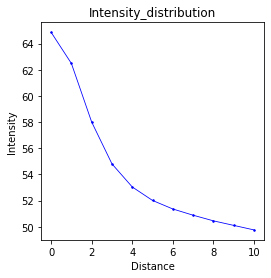

progress bar: 1000/4849

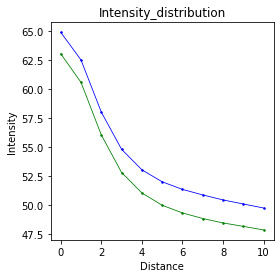

progress bar: 1500/4849

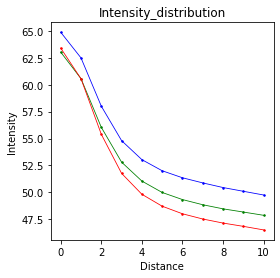

progress bar: 2000/4849

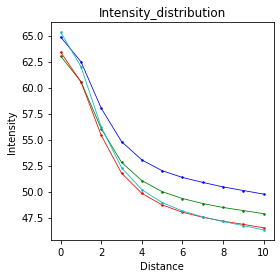

progress bar: 2500/4849

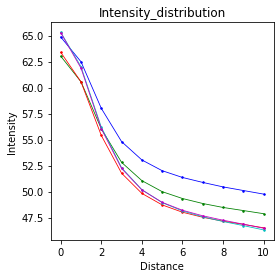

progress bar: 3000/4849

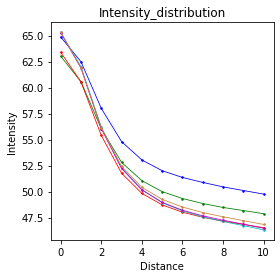

progress bar: 3500/4849

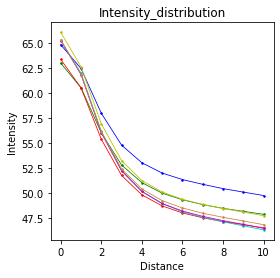

progress bar: 4000/4849

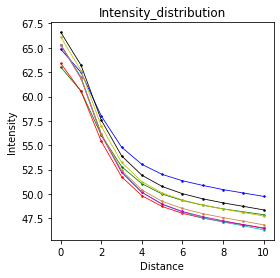

progress bar: 4500/4849

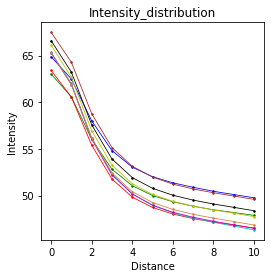

progress bar: 4849/4849

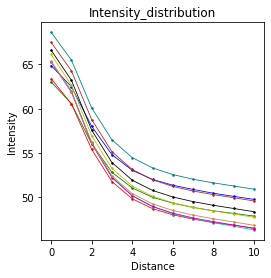

In [150]:
all_x_aver,all_y_aver=plot_curves('/home/braincenter5/Desktop/bouton_detection/for_allen/mouse17782_00001/',10,500)

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


0

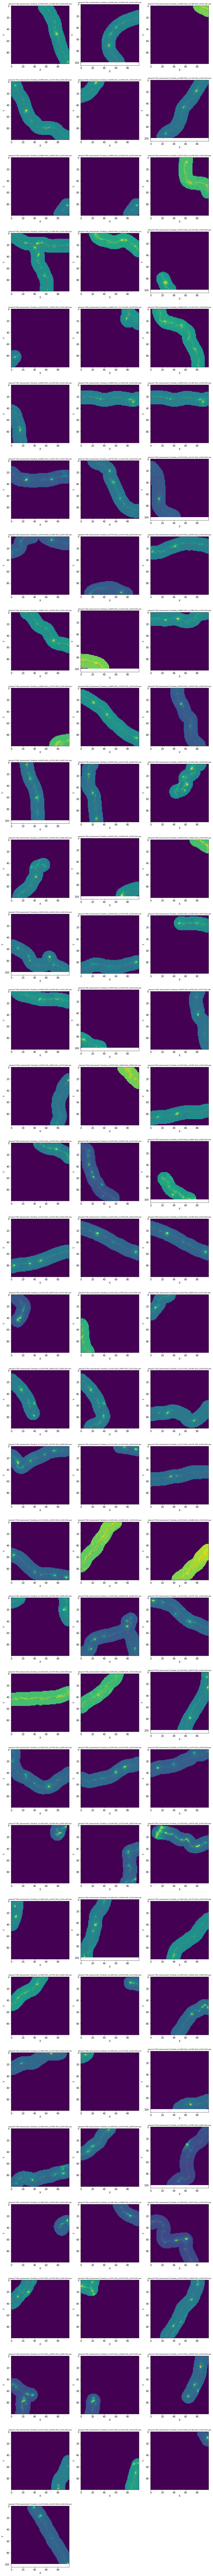

In [23]:
plot_mip_lines('/home/braincenter5/Desktop/bouton_detection/for_allen/mouse17782_00001/',10,100)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [67.60716365754223, 65.30296361502347, 61.09201873256277, 58.275377859477125, 56.641265503468574, 55.63959227467811, 55.00049428822496, 54.536146622921144, 53.984464431725264, 53.54885505335092, 53.12849919842151]


Text(0, 0.5, 'Intensity')

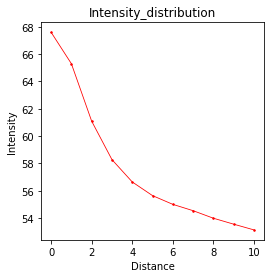

In [146]:
print(x_aver,y_aver)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_aver,y_aver,'r.',markersize=3,c='r')# plot red nodes 
ax.plot(x_aver,y_aver,linewidth=0.8,c='r',label='Total curve')#plot red lines
ax.set_title('Intensity_distribution',fontsize=12)
ax.set_xlabel('Distance')
ax.set_ylabel('Intensity')

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


progress bar: 200/4849

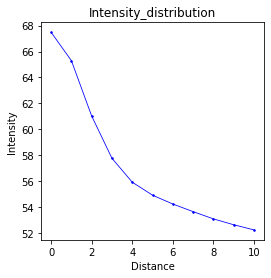

In [141]:
x_before,y_after=plot_curves('/home/braincenter5/Desktop/bouton_detection/for_allen/mouse17782_00001/',10,200,200)

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


progress bar: 200/2883

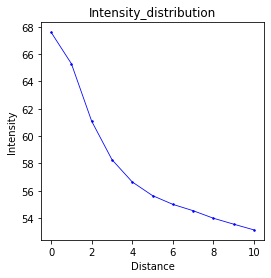

In [142]:
x_aver,y_aver=plot_curves('/home/braincenter5/Desktop/PB/ouyang/17782_unrefine_block/17782_00001_unre_block/',10,200,200)

Text(0, 0.5, 'Intensity')

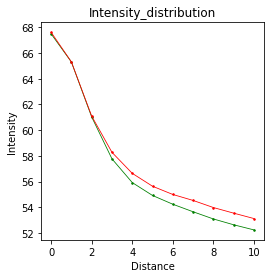

In [143]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_before,y_after,'g.',markersize=3)# plot red nodes 
ax.plot(x_before,y_after,linewidth=0.8,c='g',label='Total curve')#plot red lines
ax.plot(x_aver,y_aver,'r.',markersize=3)# plot red nodes 
ax.plot(x_aver,y_aver,linewidth=0.8,c='r',label='Total curve')#plot red lines
ax.set_title('Intensity_distribution',fontsize=12)
ax.set_xlabel('Distance')
ax.set_ylabel('Intensity')

In [1493]:
#k,c,xs,xe,xc,yc=vertical_line('/home/braincenter5/Desktop/test22/ring_test/test_swc/swc_multi','mouse17782_teraconvert_TeraSub_x31095.000_y17145.000_z2475.000.swc',100,10)

In [1054]:
#a,b=go_through_swc('/home/braincenter5/Desktop/test22/ring_test/test_swc/swc','mouse17782_teraconvert_TeraSub_x32805.000_y17415.000_z3285.000.swc')

# below is selecting bouton using signal distribution in two vertical lines 

In [34]:
def vertical_line_constrain(swc_path,swc_name,marker_name,mip,line_half_length):
    swc=pd.read_csv(swc_path+'/'+swc_name,sep='/t',header=None)
    marker_data=pd.read_csv(swc_path+'/'+marker_name,sep=',',header=None)
    n_pn={}
    n_i={}
    num=0
    
    #get n_np and n_i
    for i in range(len(swc)):
        prefix=str(swc.iloc[i][0])
        if prefix.startswith( "#" ):#exclude the lines who startswith '#'
            continue 
        if len(prefix.split(' '))>2:
            if int(prefix.split(' ')[1])!=2:#exclude the nodes whose type!=2
                continue
            elif int(prefix.split(' ')[6])==-1:
                num=num-1 #change all root node to -1,-2,-3,-4...
                n_pn[int(prefix.split(' ')[0])]=num
                n_i[int(prefix.split(' ')[0])]=i
            elif int(prefix.split(' ')[6])!=-1:
                n_pn[int(prefix.split(' ')[0])]=int(prefix.split(' ')[6]) #dict: n -> pn
                n_i[int(prefix.split(' ')[0])]=i #dict: n -> i
   

    x_center=[]
    y_center=[]
    k=[]
    c=[] 
    x_s=[]
    x_e=[]
    ints_swc_line_all=[]
    dis_swc_line_all=[]
    for i in range(len(marker_data)):
        index_dist={}
        prefix=str(marker_data.iloc[i][0])
        if prefix.startswith( "#" ):#exclude the title line
            continue
        else:
            x=float(marker_data.iloc[i][0])#marker's coordinate
            y=float(marker_data.iloc[i][1])
            z=float(marker_data.iloc[i][2])
            x_center.append(x)
            y_center.append(50-y)
            cnt=0
            for j in range(len(swc)):
                prefix1=str(swc.iloc[j][0])
                if prefix1.startswith( "#" ):#exclude the title line
                    cnt=cnt+1
                    continue
                else: 
                    x1=float(prefix1.split(' ')[2])
                    y1=float(prefix1.split(' ')[3])
                    z1=float(prefix1.split(' ')[4])
                    dist=math.sqrt((x1-x)**2+(y1-y)**2+(z1-z)**2)
                    index_dist[j]=dist #!!!!!!!dict:swc(include '#') index and dist 
        min_dist=zip(index_dist.values(),index_dist.keys())
        min_dist=min(min_dist)#find the shortest distance swc node away from current marker
        cur_n=min_dist[1]-cnt+1 #the closest swc node away from current marker
        
        
        
        ints_swc_line,dis_swc_line=swc_line_nodes(swc,n_pn,n_i,cur_n,cnt,5,mip,x,y)#marker's coordinate
        if ints_swc_line!=0 and dis_swc_line!=0:
            ints_swc_line_all.append(ints_swc_line)
            dis_swc_line_all.append(dis_swc_line)
        else:
            continue
        
           
        if n_pn[cur_n]!=-1:
            #current node
            prefix_n=str(swc.iloc[min_dist[1]][0])
            x_n=float(prefix_n.split(' ')[2])
            y_n=len(mip)-float(prefix_n.split(' ')[3])
            #current node's parent
            cur_parents_index=n_pn[cur_n]+cnt-1
            prefix_pn=str(swc.iloc[cur_parents_index][0])
            x_pn=float(prefix_pn.split(' ')[2])
            y_pn=len(mip)-float(prefix_pn.split(' ')[3])
            
            ki,ci=cal_vertical_lines(x_n,y_n,x_pn,y_pn)
            #print(min_dist[1],n_pn[cur_n]+cnt-1)
            ci=len(mip)-y-ki*x #make this vertical line go through the marker position
            k.append(ki)
            c.append(ci)
            
            #calculate the x range of every line:b**2-4ac
            a_line=ki*ki+1
            b_line=2*(ki*ci-ki*y-x)
            c_line=x*x+y*y+ci*ci-2*y*ci-line_half_length*line_half_length
            x11,x22=equation(a_line,b_line,c_line)
            x_s.append(x11)
            x_e.append(x22) 
        else:
            for item in n_pn.items():
                if item[1]==cur_n: #find child node
                    #current node
                    prefix_n=str(swc.iloc[min_dist[1]][0])
                    x_n=float(prefix_n.split(' ')[2])
                    y_n=len(mip)-float(prefix_n.split(' ')[3])
                    #current node's child
                    cur_childs_index=item[0]+cnt-1
                    prefix_pn=str(swc.iloc[cur_childs_index][0])
                    x_pn=float(prefix_pn.split(' ')[2])
                    y_pn=len(mip)-float(prefix_pn.split(' ')[3])
            
                    ki,ci=cal_vertical_lines(x_n,y_n,x_pn,y_pn)
                    #print(min_dist[1],n_pn[cur_n]+cnt-1)
                    ci=len(mip)-y-ki*x #make this vertical line go through the marker position
                    k.append(ki)
                    c.append(ci)
            
                    #calculate the x range of every line:b**2-4ac
                    a_line=ki*ki+1
                    b_line=2*(ki*ci-ki*y-x)
                    c_line=x*x+y*y+ci*ci-2*y*ci-line_half_length*line_half_length
                    x11,x22=equation(a_line,b_line,c_line)
                    x_s.append(x11)
                    x_e.append(x22) 
                    break     
    #print(dis_swc_line_all,ints_swc_line_all)       
    return k,c,x_s,x_e,x_center,y_center,dis_swc_line_all,ints_swc_line_all


In [39]:
def swc_line_nodes(swc,n_pn,n_i,cur_n,cnt,max_dis,mip,marker_x,marker_y):
    n=cur_n

    image_ints=[]
    x_distance=[]
    
    #find the child node below the distance of 'max_dis'
    child_nums=0
    for i in range(max_dis):
        child=False
        n_break=n
        for item in n_pn.items():
            if item[1]==n: #find child node                                      
                child=True
                cur_childs_index=item[0]+cnt-1 #current node's child
                n_break=cur_childs_index-cnt+1
                break #exclude the branch nodes
        n=n_break #the child node'n below the distance of 'max_dis'
        child_nums=i+1#the nums total find
        if not child:
            break       
    
    if child_nums<max_dis:#means marginal nodes or tip nodes,then make a straight SWC line
        prefix_n=str(swc.iloc[cur_n+cnt-1][0])#current n
        x_n=float(prefix_n.split(' ')[2])
        y_n=len(mip)-float(prefix_n.split(' ')[3])
        
        if n_pn[cur_n]!=-1:
            pns_n=n_pn[cur_n]
            prefix_pn=str(swc.iloc[pns_n+cnt-1][0])
            x_pn=float(prefix_pn.split(' ')[2])
            y_pn=len(mip)-float(prefix_pn.split(' ')[3])
        else:
            return 0,0 #exclude root node
        
        if (x_pn-x_n)!=0:
            k=(y_pn-y_n)/(x_pn-x_n)
            c=y_n-k*x_n
        else:
            k=1
            c=-x_n
        image_ints,x_distance,x_image,y_image=resample(mip,x_n,y_n,k,c,max_dis*2,marker_x,len(mip)-marker_y)
        x_distance,image_ints=(list(t) for t in zip(*sorted(zip(x_distance,image_ints))))
        print(x_distance,image_ints)
        return image_ints,x_distance
    else: #means already find all max_dis's child nodes
        for i in range(-max_dis,max_dis+1):#from lastest child node to the first one
            prefix_n=str(swc.iloc[n+cnt-1][0])#bottom n
            x_n=float(prefix_n.split(' ')[2])
            y_n=50-float(prefix_n.split(' ')[3])
            
            pns_n=n_pn[n]
            prefix_pn=str(swc.iloc[pns_n+cnt-1][0])
            x_pn=float(prefix_pn.split(' ')[2])
            y_pn=50-float(prefix_pn.split(' ')[3])
            
            x_inter=(x_n+x_pn)/2
            y_inter=(y_n+y_pn)/2
                      
            x_distance.append(i)            
            x_distance.append(i+0.5) #0.5 for index of the internal nodes
            
            if i==0:
                image_ints.append(mip[int(len(mip)-marker_y)][int(marker_x)])#the center node must be marker node
            else:
                image_ints.append(mip[int(y_n)][int(x_n)])
            image_ints.append(mip[int(y_inter)][int(x_inter)])
            
            if n_pn[pns_n] != -1:
                n=pns_n
                
            else: #when the parent nodes are enough then also draw the a straight SWC line 
                prefix_n=str(swc.iloc[cur_n+cnt-1][0])#current n
                x_n=float(prefix_n.split(' ')[2])
                y_n=50-float(prefix_n.split(' ')[3])
                for item in n_pn.items():
                    if item[1]==cur_n: #find child node                                      
                        cur_childs_index=item[0]+cnt-1 #current node's child
                        prefix_child=str(swc.iloc[cur_childs_index][0])
                        x_pn=float(prefix_child.split(' ')[2])
                        y_pn=50-float(prefix_child.split(' ')[3])
                        
                        if (x_pn-x_n)!=0:
                            k=(y_pn-y_n)/(x_pn-x_n)
                            c=y_n-k*x_n
                        else:
                            k=1
                            c=-x_n
                image_ints,x_distance,x_image,y_image=resample(mip,x_n,y_n,k,c,max_dis*2,marker_x,len(mip)-marker_y)
                x_distance,image_ints=(list(t) for t in zip(*sorted(zip(x_distance,image_ints))))
                return image_ints,x_distance
                
        x_distance=[x*2 for x in x_distance]
        return image_ints,x_distance     

In [26]:
def cal_vertical_lines(x1,y1,x2,y2):
    if y1!=y2:
        k=(x1-x2) / (y2-y1) #(k*k1=-1,k1=-1/k)
        c=y1-k*x1
    else:
        k=0
        c=y1
    return k,c #vertical line:y=k*x+c

In [27]:
import math
def equation(a,b,c):
    h=b*b-4*a*c
    if h>=0:
        x1=(-b+math.sqrt(h))/2/a  #sqrt函数求平方根
        x2=(-b-math.sqrt(h))/2/a
        x=x1
        x1=(x1 if x1>x2 else x2)
        x2=(x if x<x2 else x2)
        #x1=(99 if x1>99 else x1)
        #x2=(99 if x2>99 else x2)
        #x1=(1 if x1<1 else x1)
        #x2=(1 if x2<1 else x2)
        return(x1,x2)
    else:
        return 0,0

In [28]:
#calculate two nodes(x coordinates) of every line 
#away from center node with a distance:distance
#b**2-4ac;the center node is (x1,y1).
def resample(mip,xc,yc,k,c,max_distance,marker_x,marker_y):
    #when it doesn't need to put marker then (marker_x,marker_y=xc,yc)
    image_ints=[]
    x_distance=[]
    x_image=[]
    y_image=[]
    for distance in range(max_distance+1):
        a_line=k*k+1  #use distance to resample the vertical line
        b_line=2*(k*c-k*yc-xc)
        c_line=xc*xc+yc*yc+c*c-2*yc*c-distance*distance
        x1,x2=equation(a_line,b_line,c_line)
        y1=k*x1+c
        y2=k*x2+c
        if distance==0 and 0<yc<(len(mip)) and 0<xc<(len(mip)):
            image_ints.append(mip[int(marker_y)][int(marker_x)])
            x_distance.append(0)
        if distance!=0 and 0<x1<(len(mip)) and 0<y1<(len(mip)) and 0<x2<(len(mip)) and 0<y2<(len(mip)):
            image_ints.append(mip[int(y1)][int(x1)])
            x_distance.append(distance)             
            image_ints.append(mip[int(y2)][int(x2)])
            x_distance.append(-distance)

            x_image.append(x1) #record all nodes in vertical line
            y_image.append(y1)
            x_image.append(x2)
            y_image.append(y2)
    #print(image_ints,x_distance)       
    #df= pd.DataFrame({'image_ints':image_ints,'x_distance':x_distance})
    return image_ints,x_distance,x_image,y_image


from pylab import plot
from pylab import title
def mip_plot(mip, x, y, k, c , xs, xe, ax,title,cmap='viridis'):#color map
    ax.imshow(mip,cmap=cmap)
    
    #ax.plot(x,y,'r.',markersize=1.3)# plot red center nodes 
    for i in range(len(k)):
        xx=np.linspace(xs[i],xe[i])
        yy=list(xx*k[i]+c[i])
        xx=list(xx)
        for i in reversed(range(len(yy))):
            if yy[i]<0 or yy[i]>100 or xx[i]<0 or xx[i]>100 :
                del yy[i]
                del xx[i]
        ax.plot(xx,yy,color='red',linewidth=0.6)#plot red vertical line nodes
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title,fontsize=7)
    return ax

In [29]:
#k,c,x_s,x_e,x_center,y_center=vertical_line_constrain('/home/braincenter5/Desktop/1.14_boouton_test','RES(28000x45000x11786)_TeraSub_x11385.000_y10845.000_z3285.000.swc',
 #                                                    'RES(28000x45000x11786)_TeraSub_x11385.000_y10845.000_z3285.000.swc_3Dmask.final.marker',100,10)
#print(k,c,x_s,x_e,x_center,y_center)

In [30]:
mip_dict={'XY':0,'XZ':1,'YZ':2}
def plot_mip_lines(nrrd_path,marker_name,max_distance,nums):
    sample_list = sorted([i for i in os.listdir(nrrd_path) if i.endswith("mask.tif")])
    #plot mask_image and vertical line
    color=['b','g','r','c','m','peru','y','k','brown','teal','cyan','coral','gold']
    fig=plt.figure(figsize=(55,20*nums/3))
    ax=[]
    for i in range(nums):
        ax_i=fig.add_subplot(int(nums/3)+1,3,i+1)
        ax.append(ax_i)  
    for n_sample in range(nums):
        img = sitk.ReadImage(nrrd_path+sample_list[n_sample])
        array = sitk.GetArrayFromImage(img)
        mip = np.max(array, axis=mip_dict['XY'])
        ax[n_sample].imshow(mip,cmap='viridis')
        swc_name=sample_list[n_sample].split('_3D')[0] #find all swcs using tif's name
        k,c,xs,xe,xc,yc=vertical_line_constrain(nrrd_path,swc_name,marker_name,len(mip),max_distance)
        for i in range(len(k)): #plot nodes in every vertical line
            ints,dis,x_image,y_image=resample(mip,xc[i],yc[i],k[i],c[i],max_distance)
            ax[n_sample].plot(x_image,y_image,'.',color=color[i],markersize=1.3)# plot red center nodes 
            ax[n_sample].plot(x_image,y_image,color=color[i],linewidth=0.7,label='Marker'+str(i+1))# plot red center nodes 
            plt.text(x_image[0],y_image[0],'%s'%('Marker'+str(i+1)),fontsize=10,color='white')
        ax[n_sample].set_xlabel('X')
        ax[n_sample].set_ylabel('Y')
        ax[n_sample].set_title(str(swc_name),fontsize=7)
        ax[n_sample].legend(loc='upper left')
            #mip_plot(mip,x,y,k,c,xs,xe,ax[n_sample],swc_name)#there are the final x&y match with mip! 
    return 0

In [31]:
import time
def plot_curves_constrain(nrrd_path,marker_name,max_distance,batch,twosides=False,end_num=None):
    sample_list = sorted([i for i in os.listdir(nrrd_path) if i.endswith("mask.tif")])
    color=['b','r','c','m','peru','y','k','brown','teal','cyan','coral','gold']
    
    #plot a figure and save all ax
    fig1=plt.figure(figsize=(55,25*len(sample_list)/3))
    ax1=[]
    for i in range(len(sample_list)):
        ax_i=fig1.add_subplot(int(len(sample_list)/3)+1,3,i+1) #add subplot(row,column,current)
        ax1.append(ax_i)  
        
        
    #plot swc_line   
    fig2=plt.figure(figsize=(55,25*len(sample_list)/3))
    ax2=[]
    for i in range(len(sample_list)):
        ax_i=fig2.add_subplot(int(len(sample_list)/3)+1,3,i+1) #add subplot(row,column,current)
        ax2.append(ax_i)  

    #go through all tifs
    for n_sample, nrrd in enumerate(sample_list): 
        print(n_sample)
        img = sitk.ReadImage(nrrd_path+nrrd)
        array = sitk.GetArrayFromImage(img)
        mip = np.max(array, axis=mip_dict['XY'])
        swc_name=nrrd.split('_3D')[0] #find all swcs using tif's name
        if os.path.exists(nrrd_path+swc_name):
            k,c,xs,xe,xc,yc,dis_swc_line,ints_swc_line=vertical_line_constrain(nrrd_path,swc_name,marker_name,mip,max_distance)
            for j in range(len(dis_swc_line)):
                #plot all swc_line's nodes
                ax2[n_sample].plot(dis_swc_line[j],ints_swc_line[j],'.',color=color[j],markersize=3)# plot red nodes 
                ax2[n_sample].plot(dis_swc_line[j],ints_swc_line[j],color=color[j],linewidth=0.8,label='Marker'+str(j+1))#plot red lines
                max_index=ints_swc_line[j].index(max(ints_swc_line[j]))
                ax2[n_sample].text(dis_swc_line[j][max_index],ints_swc_line[j][max_index],'%s'%('Marker'+str(j+1)),fontsize=10)       
        else:
            print('Cannot find swc file!')
            continue
        ax2[n_sample].set_title('Intensity distribution of SWC derection:\n'+swc_name,fontsize=15)
        ax2[n_sample].set_xlabel('Distance',fontsize=15)
        ax2[n_sample].set_ylabel('Intensity',fontsize=15) 
        ax2[n_sample].legend(loc='upper right') 
        plt.savefig("/home/braincenter5/Desktop/bouton_detection/17302s/28evaluation_data_11.8/bouton1.pdf")

        #print('###TIF:%s\n###SWC:%s' % (nrrd,swc_name))
        
        #plot the distribution of every vertical line
        for i in range(len(k)):
            x_dis=[]
            y_oneside=[]
            ints,dis,x_image,y_image=resample(mip,xc[i],yc[i],k[i],c[i],max_distance,xc[i],yc[i])
            if not ints or not dis: #exclude empty list
                continue
            dis,ints=(list(t) for t in zip(*sorted(zip(dis,ints))))#zip:sort list1 and list2 with the dis's order
            dataframe_all = pd.DataFrame({'ints,':ints,'dist':dis})
            
            if twosides:
                for j in range(-max_distance,max_distance+1):
                    x_dis.append(j) 
                    y_oneside.append(dataframe_all[dataframe_all.dist==j].mean().iloc[0]) #calculate the average of rows
            else:           
                for j in range(max_distance+1):
                    x_dis.append(j) 
                    y_oneside.append(dataframe_all[abs(dataframe_all.dist)==j].mean().iloc[0]) #calculate the average of rows   
            
            ax1[n_sample].plot(x_dis,y_oneside,'.',color=color[i],markersize=3)# plot red nodes 
            ax1[n_sample].plot(x_dis,y_oneside,color=color[i],linewidth=0.8,label='Marker'+str(i+1))#plot red lines
            
            y_remove=y_oneside #make nan as 0
            for j in reversed(range(len(y_remove))):
                if np.isnan(y_remove[j]):
                    y_remove[j]=0
            
            max_index=y_oneside.index(max(y_remove)) #find the index of maxmum value
            ax1[n_sample].text(x_dis[max_index],y_remove[max_index],'%s'%('Marker'+str(i+1)),fontsize=10)
        
        ax1[n_sample].set_title('Intensity distribution of vertical line:\n'+swc_name,fontsize=15)
        ax1[n_sample].set_xlabel('Distance',fontsize=15)
        ax1[n_sample].set_ylabel('Intensity',fontsize=15) 
        ax1[n_sample].legend(loc='upper right')
        plt.savefig("/home/braincenter5/Desktop/bouton_detection/17302s/28evaluation_data_11.8/bouton2.pdf")
        
        #print('\r', end='')
        #print('progress bar: %s/%d' % (n_sample,len(sample_list)), end='')
        #time.sleep(0.05)       
    return 0

0
[-3, -2, -1, 0, 1, 2, 3] [68, 72, 64, 80, 68, 56, 52]
[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [48, 48, 52, 52, 52, 56, 64, 72, 60, 68, 72, 92, 84, 64, 48, 48, 48, 48, 48, 48, 48]


/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


0

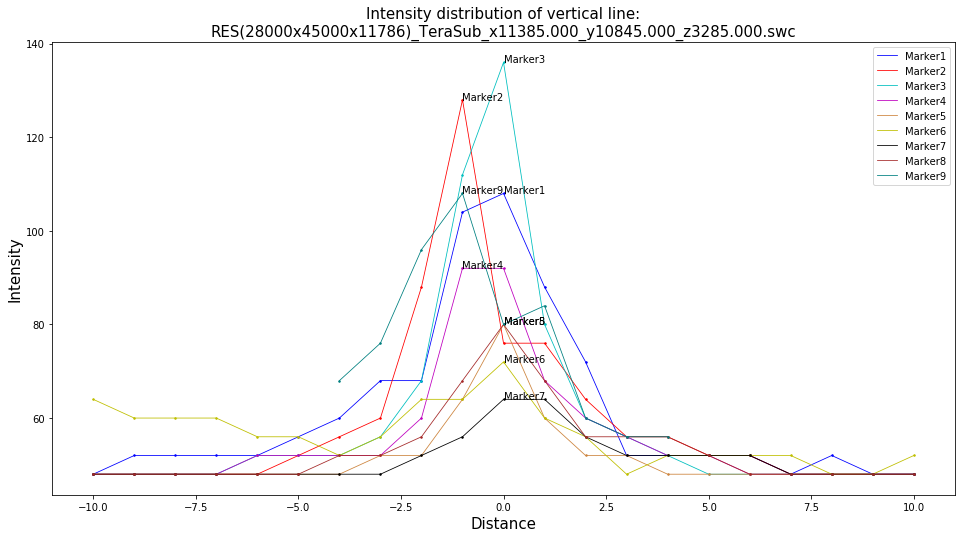

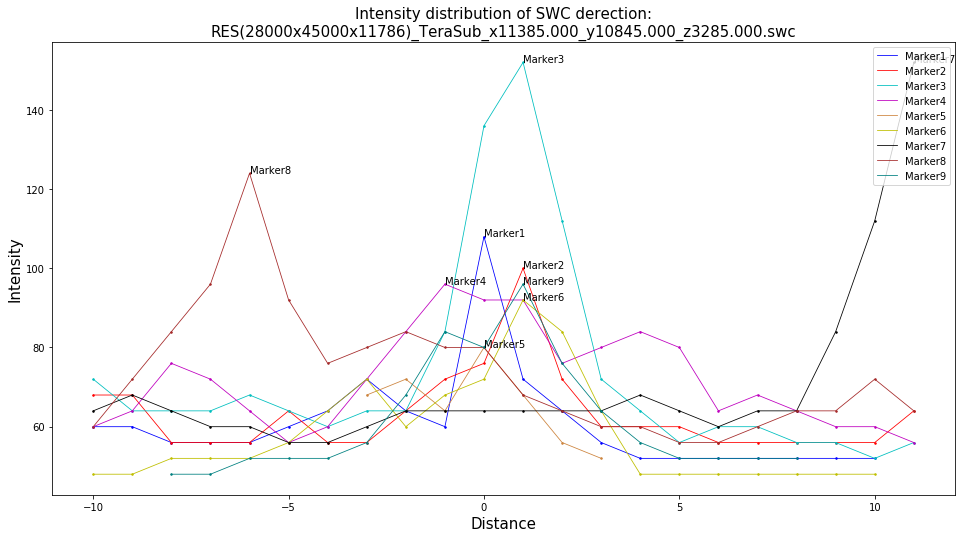

In [32]:
plot_curves_constrain('/home/braincenter5/Desktop/1.14_boouton_test/','RES(28000x45000x11786)_TeraSub_x11385.000_y10845.000_z3285.000.swc_3Dmask.tif.marker',
                     10,1,True)

/home/braincenter5/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


TypeError: 'int' object is not subscriptable

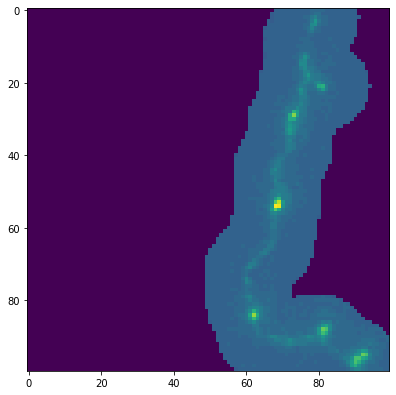

In [40]:
plot_mip_lines('/home/braincenter5/Desktop/1.14_boouton_test/','RES(28000x45000x11786)_TeraSub_x11385.000_y10845.000_z3285.000.swc_3Dmask.tif.marker',10,1)